# Physics-based neural network with Sine Activation
## Motivation: 
The following sample problem will demonstrate that deep neural network can be utilized to approximate the solutions of partial differential equations (PDEs). This is a recent area of research, known as Physics Informed Neural Networks (PINNS). With this approach, a loss function is setup to penalize the fitted function’s deviation from the desired differential operator and boundary conditions. ﻿The main insight of this approach lies in the fact that the training data consists of randomly sampled points in the function’s domain. By sampling mini-batches from different parts of the domain and processing these small batches sequentially, the neural network “learns” the function without the computational bottleneck present with grid-based methods. 


Problem:
Let us consider a non-linear Poisson equation:
For a domain $\Omega \subset \mathbb{R}^N$ with boundary $\partial \Omega = \Gamma_{D} \cup \Gamma_{N}$, we consider the following nonlinear Poisson equation with particular boundary
conditions reads:
$$
\begin{split}- \nabla\cdot((1 + u^2) \nabla u) &= f \quad {\rm in}\, \Omega,\\
u &= 1  \quad  {\rm on}\, \Gamma_D,\\
\nabla u\cdot n &= 0 \quad  {\rm on}\, \Gamma_N.\end{split}
$$
Here $f$ is input data and  denotes the outward directed boundary normal. The nonlinear variational form can be written in the following canonical form: find $u \in V$  such that
$$
F(u;v)=0\quad \forall\,v\in\hat{V}
$$
Here $F:V\times\hat{V}\rightarrow\mathbb{R}$  is a semilinear form, linear in the argument subsequent to the semicolon, and $V$  is some suitable function space. The semilinear form is defined as follows:
$$
F(u;v) = \int_\Omega (1 + u^2)\cdot\nabla u \cdot \nabla v - f v \,{\rm dx} = 0.
$$
To solve the nonlinear system $b(U) = 0$  by Newton’s method we compute the Jacobian A = b', where $U$  is the coefficients of the linear combination in the finite element solution $u_h = \sum_{j=1}^{N}U_j\phi_j, \;
b:\mathbb{R}^N\rightarrow\mathbb{R}^N$  and 
$$
b_i(U) = F(u_h;\hat{\phi}_i),\quad i = 1,2,\dotsc,N.
$$
Linearizing the semilinear form $F$ around $u = u_h$, we obtain 
$$
F'(u_h;\delta u,v) = \int_\Omega [(2 \delta u\nabla u_h)\cdot\nabla v + ((1+u_h^2)\nabla\delta u)\nabla v] \,{\rm dx}
$$
We note that for each fixed $u_h$,$a = F'(u_h;\,\cdot\,,\,\cdot\,)$  is a bilinear form and $L = F(u_h;\,\cdot\,,\,\cdot\,)$  is a linear form. In each Newton iteration, we thus solve a linear variational problem of the canonical form:
find $\delta u \in V_{h,0}$ such that
$$
F'(u_h;\delta u,v) = -F(u_h;v)\quad\forall\,v\in\hat{V}_h.
$$
In this demo, we shall consider the following definitions of the input function, the domain, and the boundaries:

* $\Omega = [0,1] \times [0,1]\,\,\,$  (a unit square)
* $\Gamma_{D} = \{(1, y) \subset \partial \Omega\}\,\,\,$   (Dirichlet boundary)
* $\Gamma_{N} = \{(x, 0) \cup (x, 1) \cup (0, y) \subset \partial \Omega\}\,\,\,$  (Neumann boundary)
* $f(x, y) = x\sin(y)\,\,\,$  (source term)

## Import Library

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from dolfin import *

## Compute the error with reference solution on a grid of \[200,200\]

### PDE Solver with FEniCS library

How does the overall error for $u$  decreases as you increase the mesh size to \[10,10\], \[20,20\] and \[40,40\]? Use a reference solution on a grid of \[200,200\] to compute the error.

In [2]:
class DirichletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - 1.0) < DOLFIN_EPS and on_boundary

def PDE_Solver(Nx, Ny):
    if has_linear_algebra_backend("Epetra"):
        parameters["linear_algebra_backend"] = "Epetra"

    # Create mesh and define function space 
    mesh = UnitSquareMesh(Nx, Ny)
    File("mesh.pvd") << mesh

    V = FunctionSpace(mesh, "CG", 1)

    # Define boundary condition
    g = Constant(1.0)
    bc = DirichletBC(V, g, DirichletBoundary())


    # Define variational problem 
    u = Function(V)
    v = TestFunction(V)
    f = Expression("x[0]*sin(x[1])", degree=2)
    F = inner((1 + u**2) * grad(u), grad(v)) * dx - f * v * dx


    # Compute solution 
    solve(F == 0, u, bc, solver_parameters={"newton_solver" : {"relative_tolerance" : 1e-6} })

    Output = u.compute_vertex_values(mesh)
    Input = 2 * mesh.coordinates() - 1

    return Input, Output, u

In [3]:
_, _, u_10 = PDE_Solver(10, 10) # Sample1
_, _, u_20 = PDE_Solver(20, 20) # Sample2
_, _, u_40 = PDE_Solver(40, 40) # Sample3

_, _, u_200 = PDE_Solver(200, 200) # Reference

In [4]:
Error1 = errornorm(u_10, u_200)
Error2 = errornorm(u_20, u_200)
Error3 = errornorm(u_40, u_200)

print("Error Norm in grad[10,10] : {}".format(Error1))
print("Error Norm in grad[20,20] : {}".format(Error2))
print("Error Norm in grad[40,40] : {}".format(Error3))

Error Norm in grad[10,10] : 0.00017628328209209516
Error Norm in grad[20,20] : 4.4068054925008774e-05
Error Norm in grad[40,40] : 1.0742567433924942e-05


### Sine Layer

In [5]:
class SineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(SineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
                                                       maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = tf.sin(self.omega_0 * befor_activation)
        return after_activation

In [90]:
tf.keras.backend.clear_session() # clear keras session

In [99]:
omega_0 = 15 # Hyper Parameter
hidden_units = 32 
# initializers for output layer
hidden_initializers = tf.keras.initializers.RandomUniform(minval=-np.sqrt(6/hidden_units)/omega_0,
                                                          maxval=np.sqrt(6/hidden_units)/omega_0)

In [100]:
X = tf.keras.layers.Input(shape=(2,))

# Since network
x = SineLayer(2, hidden_units, is_first=True, omega_0=omega_0)(X)
Y = tf.keras.layers.Dense(1, kernel_initializer=hidden_initializers)(x)

# Relu Network
#x = tf.keras.layers.Dense(hidden_units, activation="relu")(X)
#Y = tf.keras.layers.Dense(1)(x)


model = tf.keras.models.Model(X, Y)

In [101]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
sine_layer_1 (SineLayer)     (None, 32)                96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [102]:
LR_Coordinates, LR, _ = PDE_Solver(10, 10) #Input resolution for training time
HR_Coordinates, HR, _ = PDE_Solver(100, 100) # Resolution for test network

In [103]:
train_dataset = tf.data.Dataset.from_tensor_slices((LR_Coordinates, LR))
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(128)

valid_dataset = tf.data.Dataset.from_tensor_slices((HR_Coordinates, HR))
valid_dataset = valid_dataset.batch(128)

In [104]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss = tf.keras.losses.MeanSquaredError()

In [105]:
model.compile(optimizer=optimizer, loss=loss)

In [106]:
Epoch = 300
history = model.fit(train_dataset,
                    epochs=Epoch,
                    validation_data=valid_dataset)

s 6ms/step - loss: 2.8978e-07 - val_loss: 2.3696e-07
Epoch 118/300
95/95 [==============================] - 1s 6ms/step - loss: 2.8318e-07 - val_loss: 2.3124e-07
Epoch 119/300
95/95 [==============================] - 1s 6ms/step - loss: 2.7678e-07 - val_loss: 2.2566e-07
Epoch 120/300
95/95 [==============================] - 1s 6ms/step - loss: 2.7053e-07 - val_loss: 2.2028e-07
Epoch 121/300
95/95 [==============================] - 1s 6ms/step - loss: 2.6440e-07 - val_loss: 2.1510e-07
Epoch 122/300
95/95 [==============================] - 1s 6ms/step - loss: 2.5839e-07 - val_loss: 2.0998e-07
Epoch 123/300
95/95 [==============================] - 1s 7ms/step - loss: 2.5247e-07 - val_loss: 2.0484e-07
Epoch 124/300
95/95 [==============================] - 1s 7ms/step - loss: 2.4662e-07 - val_loss: 1.9982e-07
Epoch 125/300
95/95 [==============================] - 1s 7ms/step - loss: 2.4082e-07 - val_loss: 1.9507e-07
Epoch 126/300
95/95 [==============================] - 1s 6ms/step - loss: 

In [107]:
predicted = model(HR_Coordinates)

In [108]:
model.evaluate(HR_Coordinates, HR) # Test Error

319/319 [==============================] - 1s 3ms/step - loss: 2.0752e-08


2.0752212392949332e-08

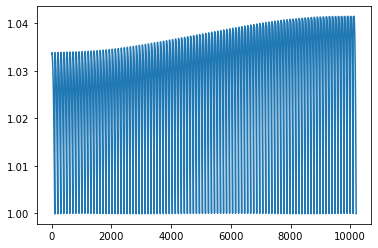

In [109]:
plt.plot(predicted) # Predicted

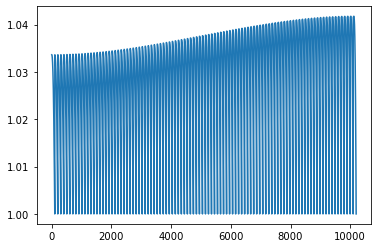

In [110]:
plt.plot(HR) # Original